# VAE and VSC for Cell Images

In [1]:
import torch
from torch import cuda
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils import data
from torchvision.utils import save_image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
data_dir = '../../../Data/'
results_dir = '../../../results/'
batch_size = 128

torch.manual_seed(22)
device = torch.device("cuda" if cuda.is_available() else "cpu")
print(device)

cuda


The following code is a utility to load and split the data given the path where the data is stored, pytorch keeps the folder names as labes as if it was a classification task, but they can just be ignored when using the data loaders. Since the task at hand is from a very specific domain (biology and cell images) the normalization values that are often used for computer vision tasks cannot be used. The mean and std used to normalize the dataset was pre computed from a small sample of the dataset and might not be accurate, but it seems to work well right now

In [3]:
def split_data(data_dir, n_split=0.2, batch_size=256):
    
    pin_memory = cuda.is_available()
    workers = 0 if cuda.is_available() else 4
    
    # Create training and validation datasets
    image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize((0.0302, 0.0660, 0.0518), (0.0633, 0.0974, 0.0766))
    ]))
    # Create training and validation dataloaders
    total = len(image_dataset)
    n_test = int(total * n_split)
    n_train = total - n_test 
    train_set, test_set = data.random_split(image_dataset, (n_train, n_test))

    n_val = int(len(train_set) * n_split)
    n_train = len(train_set) - n_val
    train_set, val_set = data.random_split(train_set, (n_train, n_val))  
    
    print('Train split: ', len(train_set))
    print('Val split: ', len(val_set))
    print('Test split: ', len(test_set))
    
    train_loader = data.DataLoader(
      train_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    val_loader = data.DataLoader(
      val_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    test_loader = data.DataLoader(
      test_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    return train_loader, val_loader, test_loader

Helper function to view tensors as a plot

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.0302, 0.0660, 0.0518])
    std = np.array([0.0633, 0.0974, 0.0766])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

## Variational AutoEncoder

The previous work this is based on had an specific VAE architecture implemented in TensorFlow, the first step was to migrate that NN to Pytorch keeping the same layers and the same operations that were done in the encoder and autoencoder, as well as to keep the same loss fuction

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        channels = 'placeholder'
        # Encoder
        self.encoder_conv1 = self.getConvolutionLayer(3, 128)
        self.encoder_conv2 = self.getConvolutionLayer(128, 64)
        self.encoder_conv3 = self.getConvolutionLayer(64, 32)
        
        self.flatten = nn.Flatten()

        self.encoder_fc1 = nn.Linear(4608, self.latent_dim)
        self.encoder_fc2 = nn.Linear(4608, self.latent_dim)
        
        # Decoder
        self.decoder_fc1 = nn.Sequential(
            nn.Linear(self.latent_dim, 4608),
            nn.ReLU()
        )
        # Reshape to 32x12x12
        self.decoder_upsampler1 = nn.Upsample(scale_factor=(2,2) ,mode='nearest')
        
        self.decoder_deconv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=(2,2) ,mode='nearest')
        )
        # 48x48x64
        self.decoder_deconv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=(2,2) ,mode='nearest')
        )

        self.decoder_conv1 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=1)
        # 96x96x128
        

    def getConvolutionLayer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )


    def encode(self, x):
        x = self.encoder_conv1(x)
        x = self.encoder_conv2(x)
        x = self.encoder_conv3(x)
        
        x = self.flatten(x)
        mu = self.encoder_fc1(x)
        sigma = self.encoder_fc2(x)

        return mu, sigma

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        # Keeps shape, samples from normal dist with mean 0 and variance 1
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.decoder_fc1(z)
        z = self.decoder_upsampler1(z.view(-1, 32, 12, 12))
        z = self.decoder_deconv1(z)
        z = self.decoder_deconv2(z)
        recon = self.decoder_conv1(z)        
        return recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

From what I've seen MSE and KLD and somewhat incompatible depending on how the scores are aggregated. It either has to be sum or mean, choosing different aggregation techniques results in the difference between scores being too different and the NN will end up optimizing the one that has the bigger impact. Current solution is B-Vae where a B parameter is added to the KLD as to control how much importance it has in the loss function; KLD and MSE are aggregated by sum.

In [6]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, epoch_n=False):
    
    mse = F.mse_loss(recon_x, x, reduction='sum')
    
    # mse = torch.mean(torch.sum((x - recon).pow(2), dim=(1,2,3)))
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    
    #kld = torch.mean(-0.5 * torch.sum(1 + torch.log(1e-10 + sigma.pow(2)) - mu.pow(2) - sigma.pow(2)))
    #kld = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), axis=1))
    
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 20
    
    
    loss = mse + kld
    return loss, mse, kld

Helpers for the model training and testing loop 

In [7]:
def train(epoch, train_loader):
    model.train()
    train_loss = 0
    train_mse = 0
    train_kld = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, mse, kld = loss_function(recon_batch, data, mu, logvar, epoch)
        
        loss.backward()
        optimizer.step()
        
        current_batch_size = len(data)
        train_loss += loss.item()
        train_mse += mse.item()
        train_kld += kld.item()

  
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / current_batch_size))

    datapoints = len(train_loader.dataset)
    avg_loss = train_loss/datapoints
    avg_mse = train_mse/datapoints
    avg_kld = train_kld/datapoints

    print('====> Epoch: {} Average loss: {:.8f}'.format(epoch, avg_loss))
    print('*** Avg MSE: {:.4f}'.format(avg_mse))
    print('*** Avg KLD: {:.8f}'.format(avg_kld))
    return avg_loss, avg_mse, avg_kld

In [8]:
def test(epoch, test_loader):
    model.eval()
    test_loss = 0
    test_mse = 0
    test_kld = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, mse, kld = loss_function(recon_batch, data, mu, logvar, epoch)

            current_batch_size = data.size(0)
            test_loss += loss.item()
            test_mse += mse.item()
            test_kld += kld.item()

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch[:n]]).cpu()
                comparison = torchvision.utils.make_grid(comparison)
                imshow(comparison)
                plt.savefig(results_dir + 'reconstruction_' + str(epoch) + '.png')
                plt.close()
                #save_image(comparison, results_dir + 'reconstruction_' + str(epoch) + '.tif')

    datapoints = len(test_loader.dataset)
    test_loss /= datapoints
    test_mse /= datapoints
    test_kld /= datapoints
    print('====> Test set loss: {:.8f}'.format(test_loss))
    print('*** Avg MSE: {:.8f}'.format(test_mse))
    print('*** Avg KLD: {:.8f}'.format(test_kld))
    return test_loss, test_mse, test_kld

### Training
The training of the migrated VAE starts here

In [9]:
train_data, val_data, test_data = split_data(data_dir=data_dir, batch_size=batch_size)

Train split:  26634
Val split:  6658
Test split:  8322


In [10]:
model = VAE(256).to(device)
model

VAE(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten()
  (encoder_fc1): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc2): Linear(in_features=4608, out_features=256, bias=True)
  (decoder_fc1): Sequential(
    (0): Linear(in_features=256, out_features=4608, bias=True)
    (1): ReLU()
  )
  (decoder_upsampler1): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
  (decoder_deco

In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_trace = {
    'loss': [],
    'mse': [],
    'kld': []
}

val_trace = {
    'loss': [],
    'mse': [],
    'kld': []
}
epochs = 60
for epoch in range(1, epochs + 1):
        loss, mse, kld = train(epoch, train_data)
        train_trace['loss'].append(loss)
        train_trace['mse'].append(mse)
        train_trace['kld'].append(kld)

        loss, mse, kld = test(epoch, val_data)
        val_trace['loss'].append(loss)
        val_trace['mse'].append(mse)
        val_trace['kld'].append(kld)

        with torch.no_grad():
            sample = torch.randn(4, 256).to(device)
            sample = model.decode(sample).cpu()
            sample = torchvision.utils.make_grid(sample)
            imshow(sample)
            plt.savefig(results_dir + 'sample_' + str(epoch) + '.png')
            plt.close()
            #save_image(sample, results_dir + 'sample_' + str(epoch) + '.tif')

Train Epoch: 1 [0/26634 (0%)]	Loss: 32261.302734
Train Epoch: 1 [6400/26634 (24%)]	Loss: 16151.497070
Train Epoch: 1 [12800/26634 (48%)]	Loss: 12147.211914
Train Epoch: 1 [19200/26634 (72%)]	Loss: 12199.304688
Train Epoch: 1 [25600/26634 (96%)]	Loss: 10953.904297
====> Epoch: 1 Average loss: 15054.76358050
*** Avg MSE: 13417.3684
*** Avg KLD: 1637.39512229
====> Test set loss: 10485.86348366
*** Avg MSE: 8629.44119533
*** Avg KLD: 1856.42232830
Train Epoch: 2 [0/26634 (0%)]	Loss: 10551.914062
Train Epoch: 2 [6400/26634 (24%)]	Loss: 9646.083984
Train Epoch: 2 [12800/26634 (48%)]	Loss: 9619.916016
Train Epoch: 2 [19200/26634 (72%)]	Loss: 9216.230469
Train Epoch: 2 [25600/26634 (96%)]	Loss: 9483.857422
====> Epoch: 2 Average loss: 9760.30744244
*** Avg MSE: 7858.5439
*** Avg KLD: 1901.76355117
====> Test set loss: 9183.24437457
*** Avg MSE: 7230.41241006
*** Avg KLD: 1952.83192227
Train Epoch: 3 [0/26634 (0%)]	Loss: 8732.134766
Train Epoch: 3 [6400/26634 (24%)]	Loss: 9407.251953
Train Epo

Train Epoch: 19 [19200/26634 (72%)]	Loss: 6548.353027
Train Epoch: 19 [25600/26634 (96%)]	Loss: 6437.306641
====> Epoch: 19 Average loss: 6446.10071068
*** Avg MSE: 4557.7379
*** Avg KLD: 1888.36281332
====> Test set loss: 6487.24717240
*** Avg MSE: 4585.95629773
*** Avg KLD: 1901.29088413
Train Epoch: 20 [0/26634 (0%)]	Loss: 6419.369141
Train Epoch: 20 [6400/26634 (24%)]	Loss: 6332.587891
Train Epoch: 20 [12800/26634 (48%)]	Loss: 6340.785156
Train Epoch: 20 [19200/26634 (72%)]	Loss: 6773.607422
Train Epoch: 20 [25600/26634 (96%)]	Loss: 6080.787598
====> Epoch: 20 Average loss: 6390.67206009
*** Avg MSE: 4514.9930
*** Avg KLD: 1875.67903807
====> Test set loss: 6429.08549865
*** Avg MSE: 4528.63879868
*** Avg KLD: 1900.44671867
Train Epoch: 21 [0/26634 (0%)]	Loss: 6329.476562
Train Epoch: 21 [6400/26634 (24%)]	Loss: 6139.691895
Train Epoch: 21 [12800/26634 (48%)]	Loss: 6593.655273
Train Epoch: 21 [19200/26634 (72%)]	Loss: 6771.357422
Train Epoch: 21 [25600/26634 (96%)]	Loss: 6014.88769

====> Epoch: 37 Average loss: 5710.90395984
*** Avg MSE: 3968.6072
*** Avg KLD: 1742.29674066
====> Test set loss: 5801.52202238
*** Avg MSE: 4056.61816604
*** Avg KLD: 1744.90389865
Train Epoch: 38 [0/26634 (0%)]	Loss: 5655.488281
Train Epoch: 38 [6400/26634 (24%)]	Loss: 5381.791016
Train Epoch: 38 [12800/26634 (48%)]	Loss: 5512.468750
Train Epoch: 38 [19200/26634 (72%)]	Loss: 5897.474121
Train Epoch: 38 [25600/26634 (96%)]	Loss: 6009.831055
====> Epoch: 38 Average loss: 5685.60875256
*** Avg MSE: 3947.4580
*** Avg KLD: 1738.15070423
====> Test set loss: 5783.81465114
*** Avg MSE: 4021.17515143
*** Avg KLD: 1762.63947162
Train Epoch: 39 [0/26634 (0%)]	Loss: 5647.678223
Train Epoch: 39 [6400/26634 (24%)]	Loss: 5621.911133
Train Epoch: 39 [12800/26634 (48%)]	Loss: 5911.040039
Train Epoch: 39 [19200/26634 (72%)]	Loss: 5518.864258
Train Epoch: 39 [25600/26634 (96%)]	Loss: 5564.152344
====> Epoch: 39 Average loss: 5658.35619210
*** Avg MSE: 3923.6586
*** Avg KLD: 1734.69760537
====> Test s

KeyboardInterrupt: 

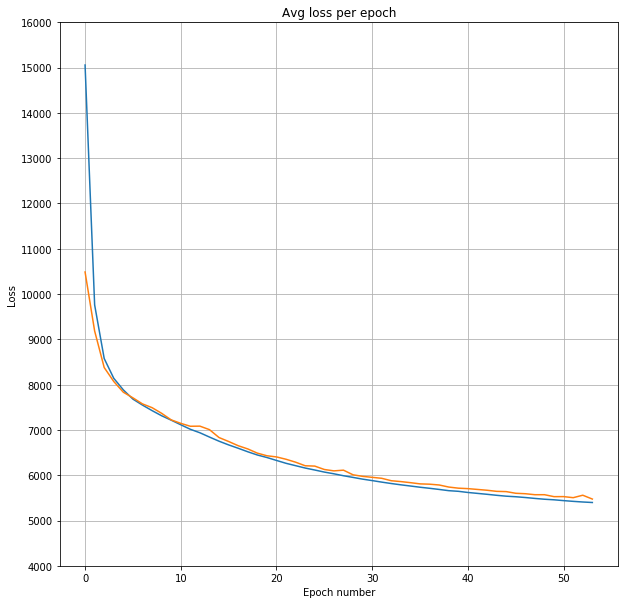

In [12]:
plt.figure(figsize=(10,10))
plt.plot(train_trace['loss'])
plt.plot(val_trace['loss'])
#plt.xticks(np.arange(0, epochs+1, 5))
plt.yticks(np.arange(4000, 16001, 1000))
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.title('Avg loss per epoch')
plt.grid()
plt.show()

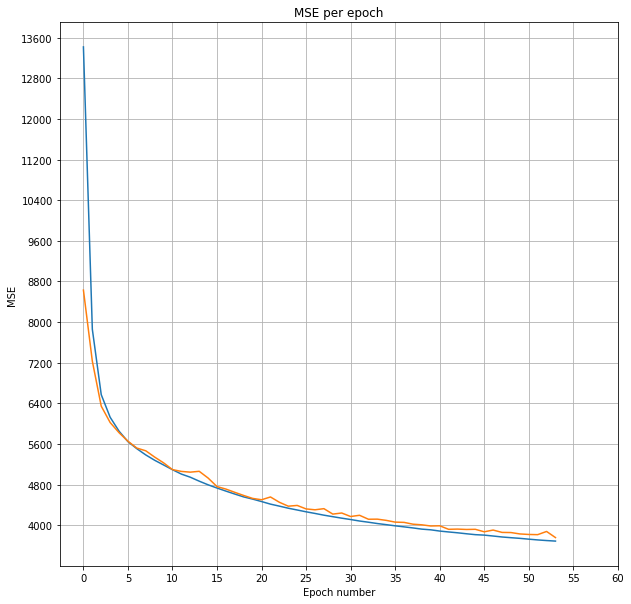

In [13]:
plt.figure(figsize=(10,10))
plt.plot(train_trace['mse'])
plt.plot(val_trace['mse'])
plt.xticks(np.arange(0, epochs+1, 5))
plt.yticks(np.arange(4000, 14001, 800))
#plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('MSE')
plt.xlabel('Epoch number')
plt.title('MSE per epoch')
plt.grid()
plt.show()

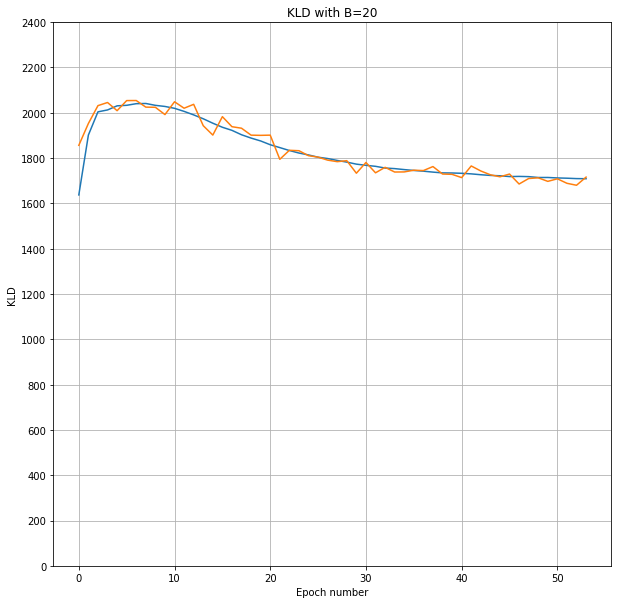

In [14]:
plt.figure(figsize=(10,10))
plt.plot(train_trace['kld'])
plt.plot(val_trace['kld'])
#plt.xticks(np.arange(0, epochs+1, 5))
plt.yticks(np.arange(0, 2500, 200))
plt.ylabel('KLD')
plt.xlabel('Epoch number')
plt.title('KLD with B=20')
plt.grid()
plt.show()

### Experimental Cells
Please ignore

In [22]:
img, _ = next(iter(val_data))
print(img.shape)
print(torch.max(img[0]))
print(torch.max(img[0][0]))
print(torch.max(img[0][1]))
print(torch.max(img[0][2]))

torch.Size([128, 3, 96, 96])
tensor(9.9212)
tensor(5.8420)
tensor(2.8252)
tensor(9.9212)


In [23]:
x = img[0:100].to(device)
recon, mu, logvar = model.forward(x)

In [24]:
loss, mse, kld = loss_function(recon, x, mu, logvar)
kld

tensor(0.4896, device='cuda:0', grad_fn=<MeanBackward0>)

In [25]:
torch.mean((-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)))

tensor(0.4896, device='cuda:0', grad_fn=<MeanBackward0>)

In [32]:
torch.sum(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

tensor(48.9608, device='cuda:0', grad_fn=<SumBackward0>)

In [27]:
-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

tensor(48.9608, device='cuda:0', grad_fn=<MulBackward0>)

In [28]:
mse

tensor(1.1142, device='cuda:0', grad_fn=<MseLossBackward>)

In [29]:
# MSE
torch.mean(torch.mean((x - recon).pow(2), dim=(1,2,3)))

tensor(1.1142, device='cuda:0', grad_fn=<MeanBackward0>)

In [30]:
# Mean of sum of squared errors
torch.mean(torch.sum((x - recon).pow(2), dim=(1,2,3)))

tensor(30805.0391, device='cuda:0', grad_fn=<MeanBackward0>)

In [31]:
torch.sum((x - recon).pow(2), dim=(1,2,3))

tensor([ 49032.4453,  40966.7852,  50848.2383,  17515.3359,  48760.9531,
         26617.5117,  18907.8516,  22738.2969,  22933.0508,  16329.3057,
         22105.6680,  15110.5820,  25839.3047,  49059.6797,  13073.6914,
         18902.3281,  37263.1523,  25110.9219,  38171.3477,  18795.6250,
         18833.7812,  16633.6133,  36964.3359,  24071.2500,  30258.8145,
         24461.3672, 152811.6406,  25291.6680,  21647.6875,  30000.3184,
         22559.1758,  25224.2891,  25710.5508,  42156.2969,  37223.4180,
         20163.1211,  20741.8828,  26796.1055,  37585.2578,  49015.0781,
         21612.6055,  35166.5898,  28960.0391,  21049.4688,  28707.4824,
         40075.3398,  34210.8906,  25009.6895,  78737.9062,  19067.6641,
         22330.2402,  34837.9492,  30266.6719,  91088.0234,  31426.5312,
         25010.1914,  35624.6719,  25312.0488,  28138.0391,  21191.1719,
         39592.9453,  27596.0156,  45610.1250,  16962.1621,  32445.0352,
         14887.0918,  15517.2236,  20838.2363,  268

In [46]:
F.mse_loss(recon, x, reduction='sum')

tensor(366448.0625, device='cuda:0', grad_fn=<MseLossBackward>)

# Extra

The cell below calculates the MEAN and STD of the data set so it can be normalized properly

In [ ]:
image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

loader = data.DataLoader(
    image_dataset,
    batch_size=128,
    num_workers=0,
    pin_memory=True,
    shuffle=False
)


mean = 0.
std = 0.
nb_samples = 0.
for dat, _ in loader:
    batch_samples = dat.size(0)
    dat = dat.view(batch_samples, dat.size(1), -1)
    mean += dat.mean(2).sum(0)
    std += dat.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print("mean: ", mean)
print("std: ", std)